In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

data = pd.read_csv("./dataset/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("./dataset/HAM10000_metadata.csv")
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [2]:
meta_df.shape
data.shape

(10015, 2353)

In [3]:
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'), 
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

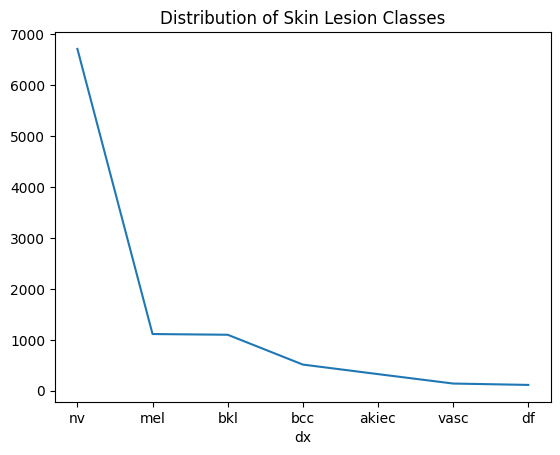

In [4]:
dist = data['label'].value_counts()
dist
distribution.plot()
plt.title('Distribution of Skin Lesion Classes')
plt.show()

In [5]:
# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler 
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

In [6]:
# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

((37548, 28, 28, 3), (9387, 28, 28, 3))

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3) 
num_classes = 7

# Resnet50

In [8]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Resnet = Model(inputs=base_model.input, outputs=predictions)

Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

In [11]:
history = Resnet.fit(Xtrain_resized, Ytrain, 
                           validation_data=(Xtest_resized, Ytest), 
                           epochs=10)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 1031s 667ms/step - accuracy: 0.5951 - loss: 1.2327 - val_accuracy: 0.5640 - val_loss: 1.5082
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 833s 709ms/step - accuracy: 0.7953 - loss: 0.6005 - val_accuracy: 0.5655 - val_loss: 1.4898
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 832s 706ms/step - accuracy: 0.8571 - loss: 0.4116 - val_accuracy: 0.8465 - val_loss: 0.4520
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 733s 624ms/step - accuracy: 0.8932 - loss: 0.3093 - val_accuracy: 0.8711 - val_loss: 0.3666
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 759s 647ms/step - accuracy: 0.9174 - loss: 0.2391 - val_accuracy: 0.6296 - val_loss: 1.8257
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 777s 662ms/step - accuracy: 0.9138 - loss: 0.2623 - val_accuracy: 0.8940 - val_loss: 0.3318
Epoch 7/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 683s 582ms/step - accuracy: 0.8823 - loss: 0.3704 - val_accuracy: 0.8874 - val_loss: 0.3229
Epoch 8/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 504s 429ms/step - a

In [12]:
from tabulate import tabulate

loss_resnet, accuracy_resnet = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.9490 - loss: 0.1878
+---------------+--------+
| Test Accuracy | 94.63% |
+---------------+--------+
| Test Loss     | 0.1958 |
+---------------+--------+


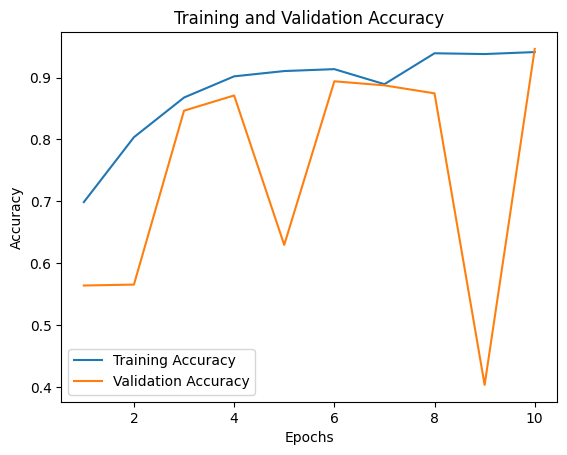

In [13]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

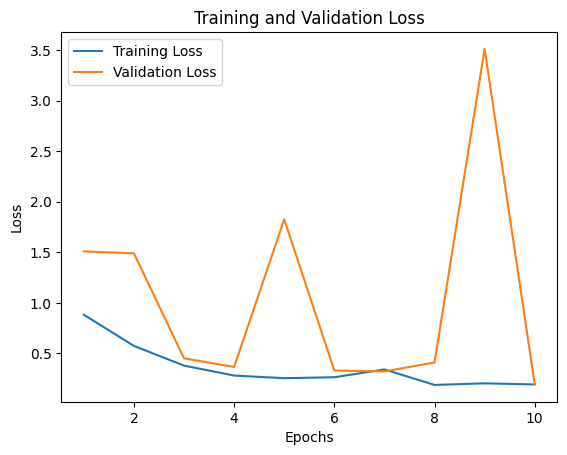

In [14]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()